Analyze SBI-SGM, new bounds, new SGM, only three parameters needed

parameters order is  :tauG,speed,alpha (In second)

## Import some pkgs

In [1]:
import sys
sys.path.append("./mypkg")
from constants import RES_ROOT, DATA_ROOT, FIG_ROOT

import scipy
import itertools

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from tqdm import trange, tqdm
from scipy.io import loadmat
from functools import partial
from easydict import EasyDict as edict
plt.style.use(FIG_ROOT/"base.mplstyle")

In [2]:
# SBI and torch
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import analysis
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as sutils

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.distributions.multivariate_normal import MultivariateNormal

In [3]:
# my own fns
from brain import Brain
from FC_utils import build_fc_freq_m
from constants import RES_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.reparam import theta_raw_2out, logistic_np, logistic_torch

## Some fns

In [4]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr
from utils.measures import geodesic_dist, reg_R_fn, lin_R_fn

def divideFc(fc):
    """Divide the FC into three blocks and vector them
    """
    size_fc = len(fc)
    hs_fc = int(size_fc/2)
    fc_block1 = fc[:hs_fc, :hs_fc]
    fc_block2 = fc[hs_fc:, hs_fc:];
    fc_block3 = fc[:hs_fc, hs_fc:];
    vec1 = _minmax_vec(fc_block1[np.triu_indices(hs_fc, k = 1)])
    vec2 = _minmax_vec(fc_block2[np.triu_indices(hs_fc, k = 1)])
    vec3 = _minmax_vec(fc_block3.flatten())
    return vec1, vec2, vec3

def cal_metrics(fc1, fc2):
    """Calculate the distance between fc1 and fc2, including
        1. geodesic dist
        2. pearson's R
        3. lin R
        4. pearson's R after divide the FC into three blocks
        5. lin R after divide the FC into three blocks
    """
    fc1 = fc1.astype(np.float64)
    fc2 = fc2.astype(np.float64)
    size_fc = len(fc1)
    
    # for geodedic
    fc1_g = fc1/np.linalg.norm(fc1) + np.eye(size_fc)
    fc2_g = fc2/np.linalg.norm(fc2) + np.eye(size_fc)
    
    fc1_c = _minmax_vec(fc1[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    fc2_c = _minmax_vec(fc2[np.triu_indices(size_fc, k=1)]).reshape(1, -1)
    
    # all metrics
    geo_dist = geodesic_dist(fc1_g, fc2_g)
    reg_r = reg_R_fn(fc1_c, fc2_c)
    lin_r = lin_R_fn(fc1_c, fc2_c)
    mse = np.mean((fc1_c-fc2_c)**2)
    tau_r = kendalltau(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    sp_r = spearmanr(fc1_c.reshape(-1), fc2_c.reshape(-1))[0]
    
    # block wise metrics
    blocks1 = divideFc(fc1)
    blocks2 = divideFc(fc2)
    reg_r_block = [reg_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    lin_r_block = [lin_R_fn(vec1.reshape(1, -1), vec2.reshape(1, -1))[0] 
                   for vec1, vec2 in zip(blocks1, blocks2)]
    
    res = edict()
    res.geo_dist = geo_dist
    res.reg_r = reg_r[0]
    res.lin_r = lin_r[0]
    res.tau_r = tau_r
    res.sp_r = sp_r 
    res.mse = mse
    res.reg_r_block = np.mean(reg_r_block)
    res.lin_r_block = np.mean(lin_r_block)
    return res

def cal_metrics_batch(fc1s, fc2s):
    """fc1s, fc2s: num_fc x 68 x 68
    """
    ress = ddict(list)
    for ix in range(len(fc1s)):
        fc_t = fc2s[ix]
        fc_e = fc1s[ix]
        res = cal_metrics(fc_t, fc_e)
        for key, v in res.items():
            ress[key].append(v)
    
    return ress

In [5]:
_minmax_vec = lambda x: (x-np.min(x))/(np.max(x)-np.min(x))

<function __main__.<lambda>(x)>

In [6]:
# transfer vec to a sym mat
def _vec_2mat(vec):
    mat = np.zeros((68, 68))
    mat[np.triu_indices(68, k = 1)] = vec
    mat = mat + mat.T
    return mat

### Some parameters

In [7]:
_paras = edict()
_paras.delta = [2, 3.5]
_paras.theta = [4, 7]
_paras.alpha = [8, 12]
_paras.beta_l = [13, 20]


In [8]:
paras = edict()

paras.bands = ["delta", "theta", "alpha", "beta_l"]
paras.freqranges =  [np.linspace(_paras[band][0], _paras[band][1], 5) 
                     for band in paras.bands]
paras.save_prefix = "rawfc2allbd"
print(paras.freqranges)
paras.fs = 600
paras.num_nodes = 86 # Number of cortical (68) + subcortical nodes
#paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
#paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
paras.par_low = np.asarray([0.005, 5, 0.1])
paras.par_high = np.asarray([0.03, 20, 1])
paras.names = ["TauC", "Speed", "alpha"]
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.prior_sd = 10
paras.add_v = 0.01
paras.k = 1
paras.nepoch = 100

paras.SBI_paras = edict()
paras.SBI_paras.num_prior_sps = int(1e3)
paras.SBI_paras.density_model = "nsf"
paras.SBI_paras.num_round = 3
paras.SBI_paras.noise_sd = 1.20
paras.SBI_paras.save_dir = (f"{paras.save_prefix}_SBIxANNALLBD_"
                            f"{'-'.join(paras.bands)}_"
                            f"ep{paras.nepoch}_"
                            f"num{paras.SBI_paras.num_prior_sps}_" 
                            f"density{paras.SBI_paras.density_model}_" 
                            f"MR{paras.SBI_paras.num_round}_" 
                            f"noise_sd{paras.SBI_paras.noise_sd*100:.0f}_"
                            f"addv{paras.add_v*100:.0f}")
print(paras.SBI_paras.save_dir)
assert (RES_ROOT/paras.SBI_paras.save_dir).exists()

[array([2.   , 2.375, 2.75 , 3.125, 3.5  ]), array([4.  , 4.75, 5.5 , 6.25, 7.  ]), array([ 8.,  9., 10., 11., 12.]), array([13.  , 14.75, 16.5 , 18.25, 20.  ])]
rawfc2allbd_SBIxANNALLBD_delta-theta-alpha-beta_l_ep100_num1000_densitynsf_MR3_noise_sd120_addv1


In [9]:
# fn for reparemetering
_map_fn_torch = partial(logistic_torch, k=paras.k)
_theta_raw_2out = partial(theta_raw_2out, map_fn=partial(logistic_np, k=paras.k), prior_bds=paras.prior_bds);

### Load the data

In [10]:
# SC
ind_conn_xr = xr.open_dataarray(DATA_ROOT/'individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values
# PSD
ind_psd_xr = xr.open_dataarray(DATA_ROOT/'individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values
fvec = ind_psd_xr["frequencies"].values;

In [11]:

def _add_v2con(cur_ind_conn):
    cur_ind_conn = cur_ind_conn.copy()
    add_v = np.quantile(cur_ind_conn, 0.99)*paras.add_v # tuning 0.1
    np.fill_diagonal(cur_ind_conn[:34, 34:68], np.diag(cur_ind_conn[:34, 34:68]) + add_v)
    np.fill_diagonal(cur_ind_conn[34:68, :34], np.diag(cur_ind_conn[34:68, :34]) + add_v)
    if cur_ind_conn.shape[0] == 68:
        return cur_ind_conn
    np.fill_diagonal(cur_ind_conn[68:77, 77:], np.diag(cur_ind_conn[68:77, 77:]) + add_v)
    np.fill_diagonal(cur_ind_conn[77:, 68:77], np.diag(cur_ind_conn[77:, 68:77]) + add_v)
    return cur_ind_conn


if paras.add_v != 0:
    print(f"Add {paras.add_v} on diag")
    ind_conn_adds = [_add_v2con(ind_conn[:, :, ix]) for ix in range(36)]
    ind_conn = np.transpose(np.array(ind_conn_adds), (1, 2, 0))

Add 0.01 on diag


In [13]:
# em FC
fc_root = RES_ROOT/"emp_fcs2"
fcss = []
for band in paras.bands:
    def _get_fc(sub_ix, bd):
        fil = list(fc_root.rglob(f"*{bd}*nepoch-{paras.nepoch}*/sub{sub_ix}.pkl"))[0]
        return load_pkl(fil, verbose=False)
    
    fcs = np.array([_get_fc(sub_ix, band) for sub_ix in range(36)]);
    fcss.append(fcs)

## All data analysis

In [14]:
res_fils = list((RES_ROOT/paras.SBI_paras.save_dir).glob("ind*.pkl"))
_sorted_fn = lambda x: int(x.stem.split("ind")[-1][:])
sorted_fils = sorted(res_fils, key=_sorted_fn);

In [ ]:
# get the estimate parameters
est_params =[]
for sub_idx in range(36):
    cur_posterior = load_pkl(sorted_fils[sub_idx], False)
    post_sps = cur_posterior.sample((1000, ))
    cur_est_paras = torch.mean(post_sps, axis=0)

    params = []
    for raw_param, prior_bd in zip(cur_est_paras, paras.prior_bds):
        param =  _map_fn_torch(raw_param)*(prior_bd[1]-prior_bd[0]) + prior_bd[0]
        params.append(param)
    params = torch.tensor(params)
    params_dict = dict()
    params_dict["tauC"] =  params[0].item()
    params_dict["speed"] =  params[1].item()
    params_dict["alpha"] =  params[2].item()
    est_params.append(params_dict)

In [17]:
def _simulate_data1(raw_params, brain, freqranges):
    ress = []
    for freqrange in freqranges:
        modelFC = build_fc_freq_m(brain , raw_params, freqrange)
        ress.append(np.abs(modelFC[:68, :68]))
    return np.array(ress)
def _get_metric(cur_params, sub_idx):
    """Get the metric for the individual with the given parameters and sub_idx
    """
    ## get the cur brain
    brain = Brain.Brain()
    brain.add_connectome(DATA_ROOT) # grabs distance matrix
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome =  ind_conn[:, :, sub_idx] # re-assign connectome to individual connectome
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    cur_est_FCs = np.abs(_simulate_data1(cur_params, brain, paras.freqranges));
    metric = []
    for band_idx in range(len(paras.bands)):
        cur_obs_FC = np.abs(fcss[band_idx][sub_idx])
        cur_est_FC = np.abs(cur_est_FCs[band_idx])
        v = cal_metrics(cur_obs_FC, cur_est_FC)
        metric.append(v)
    return metric

In [21]:
def _get_metrics(vs, param):
    """ 
    args: 
        - vs (list): the values of the parameter
        - param (str): the parameter name 
            tauC, speed, alpha
    """
    metricss = []
    for v in tqdm(vs, desc=param): 
        metrics = []
        for sub_idx in range(36):
            cur_params = est_params[sub_idx]
            cur_params = cur_params.copy()
            cur_params[param] = v
            metric = _get_metric(cur_params, sub_idx)
            metrics.append(metric)
        metricss.append(metrics)
    return metricss

In [22]:
speeds = [5, 10, 20, 30, 50, 70, 90, 110]
tauGs = [0.001, 0.002, 0.005, 0.01, 0.02, 0.03, 0.05]
alphas = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
metricss_tauC = _get_metrics(tauGs, "tauC");
metricss_alpha = _get_metrics(alphas, "alpha");
metricss_speed = _get_metrics(speeds, "speed");

speed: 100%|███████████████████████████████████████████████████████████████████████| 8/8 [02:02<00:00, 15.29s/it]


In [32]:
from collections import defaultdict as ddict
col = "mse"
names = ["tauC", "speed", "alpha"]
metricss = [metricss_tauC, metricss_speed, metricss_alpha]
vss = [tauGs, speeds, alphas]
summary = ddict(list)
for name, metricss in zip(names, metricss):
    for metrics in metricss:
        vs = []
        for band_idx in range(len(paras.bands)):
            ms = [v[band_idx] for v in metrics]
            df = pd.DataFrame(ms)
            vs.append(df.mean()[col])
        summary[name].append(np.mean(vs))

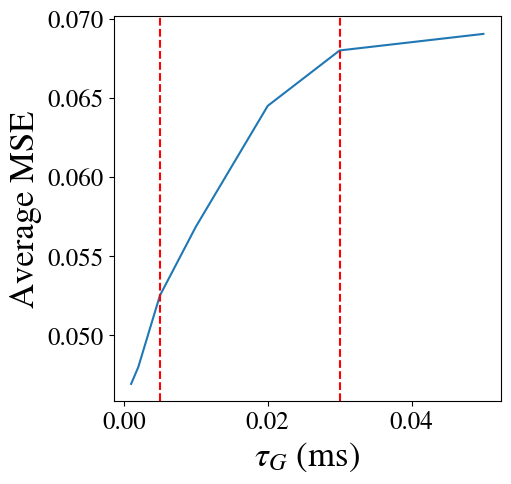

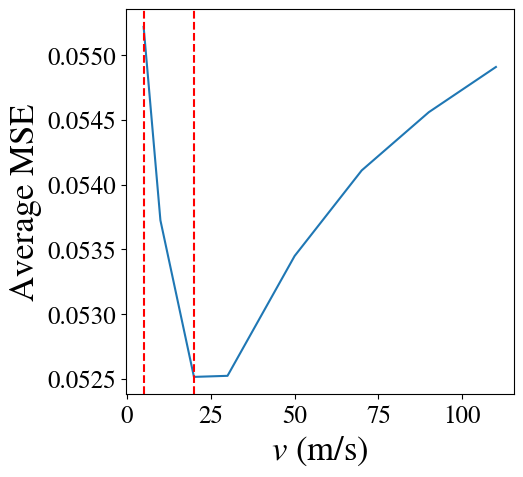

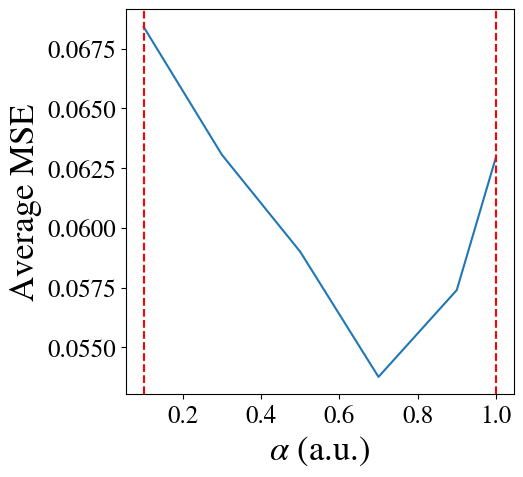

In [34]:
names_latex = ["$\\tau_G$ (ms)", "$v$ (m/s)", "$\\alpha$ (a.u.)"]
for idx in range(3):
    plt.figure(figsize=(5, 5))
    plt.plot(vss[idx], summary[names[idx]])
    plt.ylabel("Average MSE")
    plt.axvline(x=paras.par_low[idx], color="r", linestyle="--")
    plt.axvline(x=paras.par_high[idx], color="r", linestyle="--")
    plt.xlabel(f"{names_latex[idx]}")
    plt.savefig(FIG_ROOT/f"allband_param_{names[idx]}.png")